In [1]:
util_libraries <- c("foreign", "reshape2", "stargazer", "arm", "plyr", "tidyverse", "stringr", "qdapRegex", "GGally", "progress", "pracma", "lubridate", "DescTools", "irr", "psych", 'gtools', "Hmisc", "colorspace")
vis_libraries  <- c("ggplot2", "ggrepel", "grid", "gridExtra", "RColorBrewer", "scales", "corrplot", "ggeffects", "cowplot", "plot.matrix", "corrgram", "ggnetwork", "vioplot", "dotwhisker", "sjPlot", "sjlabelled", "sjmisc", "plot3D", "ggpubr", "ggExtra", "ggraph")
stat_libraries <- c("network", "sna", "igraph", "moments", "nortest", "MASS", "randomForest", "sandwich", "lmtest", "gmodels", "margins", "sampleSelection", "pROC", "pscl",  "pwr", "relaimpo", "lme4", "plm", "caret", "ResourceSelection", "rvest", "cluster", "factoextra", "outliers", "acss", 'asbio','akima', 'plotly', 'factoextra', 'interactions', 'robustbase', "sandwich", "modelr", "broom", "mgcv", "stringdist", "sem", "lavaan", "corrr", "pglm")


In [ ]:
for (l in 1:length(util_libraries)){ library(util_libraries[l], character.only = TRUE)}
for (l in 1:length(vis_libraries)){ library(vis_libraries[l], character.only = TRUE)}
for (l in 1:length(stat_libraries)){ library(stat_libraries[l], character.only = TRUE)}

In [3]:
setwd("../data/regression_data")

In [ ]:
bot_days_data<-read_csv('./bot_daily_data_to_model.csv')
bot_days_data2<-read_csv('./bot_days_data_02_23_2024.csv')
bot_days_data_opinion<-read.csv("./bot_days_data_with_opinion_filled_0308.csv")

In [5]:
bot_days_data_pre <- bot_days_data %>% mutate(time_dummy = ifelse(after_timegap_2 >-15, 1, 0),
                                         interact_dummy = bot_interaction*time_dummy) %>%
                                    filter(after_timegap_2<0)

## Parallel trend

In [24]:
s_2way <-  lm(
    senti_mean ~
      
      bot_interaction +
      time_dummy +
      bot_interaction:time_dummy+
       senti_mean_t2+
      #cascade+
      burstiness
    ,
    #data = df[df$senti_size<100 & (df$after_timegap_2<0 | (df$after_timegap_2>=-30 & df$after_timegap_2<=30)),]
    data = bot_days_data_pre,
    na.action=na.exclude
  )


In [25]:
summary(s_2way)


Call:
lm(formula = senti_mean ~ bot_interaction + time_dummy + bot_interaction:time_dummy + 
    senti_mean_t2 + burstiness, data = bot_days_data_pre, na.action = na.exclude)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.59720 -0.05831  0.00200  0.06174  1.64549 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -0.023911   0.004756  -5.027 5.04e-07 ***
bot_interaction             0.022608   0.006017   3.757 0.000172 ***
time_dummy                  0.012827   0.006926   1.852 0.064056 .  
senti_mean_t2               0.862471   0.005048 170.859  < 2e-16 ***
burstiness                  0.001273   0.002210   0.576 0.564516    
bot_interaction:time_dummy -0.016852   0.008784  -1.919 0.055064 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2438 on 13164 degrees of freedom
  (1440 observations deleted due to missingness)
Multiple R-squared:  0.6919,	Adjusted R-squar

In [26]:
a_2way <-  glm.nb(
    senti_size ~
      
     bot_interaction +
      time_dummy +
      bot_interaction:time_dummy
    ,
    #data = df[df$senti_size<100 & (df$after_timegap_2<0 | (df$after_timegap_2>=-30 & df$after_timegap_2<=30)),]
    data = bot_days_data_pre,
    na.action=na.exclude
  )

In [27]:
summary(a_2way)


Call:
glm.nb(formula = senti_size ~ bot_interaction + time_dummy + 
    bot_interaction:time_dummy, data = bot_days_data_pre, na.action = na.exclude, 
    init.theta = 0.1153440021, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6825  -0.6789  -0.6380  -0.6370   6.5790  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.30735    0.05837  -5.266  1.4e-07 ***
bot_interaction            -0.27575    0.07460  -3.697 0.000219 ***
time_dummy                  0.02431    0.08537   0.285 0.775781    
bot_interaction:time_dummy -0.03099    0.10915  -0.284 0.776487    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.1153) family taken to be 1)

    Null deviance: 6805.4  on 14609  degrees of freedom
Residual deviance: 6776.5  on 14606  degrees of freedom
AIC: 25114

Number of Fisher Scoring iterations: 1


              Theta:  0.1153

library(cobalt)
## Propsenity score

In [7]:
library(cem)
library(MatchIt)


How to use CEM? Type vignette("cem")




In [ ]:
if (!requireNamespace("cobalt", quietly = TRUE)) {
  install.packages("cobalt")
}
library(cobalt)


In [9]:
sample_and_matching <- bot_days_data %>%
  distinct(author_id_,.keep_all = TRUE) %>%
  select(author_id_, bot_interaction)# %>%
#mutate(category = ifelse(bot_interaction==1, "sample", "matching"),
#      weights = ifelse(bot_interaction==1, 1, 0))

In [10]:
all_usr = read.csv("/home/lindali/Documents/DPhil studies/thesis_work/paper 1/xr2019_users_classified_0117_wprob.csv")

In [11]:
all_usr <- all_usr %>% select('id', 'statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'followers_growth', 'friends_growth', 'favourites_growth',
       'listed_growth', 'follower_friend_ratio')

In [12]:
sample_and_matching <- merge(sample_and_matching, all_usr, by.x = "author_id_", by.y = "id", all.x = TRUE)

In [40]:
all_eculid_availables <- read.csv("/home/lindali/Documents/DPhil studies/thesis_work/paper 1/botometer/xr2019_user_matched_fifths_botometer_available.csv")

In [41]:
long_df <- all_eculid_availables %>%
  pivot_longer(cols = c("user", "matched_user"), names_to = "type", values_to = "user_ids") %>%
  mutate(bot_interaction = ifelse(type == "user", 1, 0)) %>%
  select(user_ids, bot_interaction)
long_df <- unique(long_df)

In [13]:
#df <- long_df
df <- sample_and_matching 

In [43]:
#df <- merge(df, all_usr, by.x = "user_ids", by.y = "id", all.x = TRUE)

ERROR: Error in fix.by(by.x, x): 'by' must specify a uniquely valid column


In [14]:
columns_to_convert <- c("statuses_count", "followers_count", "friends_count", "favourites_count", 
                        "listed_count", "followers_growth", "friends_growth", "favourites_growth", 
                        "listed_growth", "follower_friend_ratio")

# Convert specified columns to numeric (float)
df <- df %>% mutate_at(vars(one_of(columns_to_convert)), as.numeric)

In [20]:
m.out = matchit(bot_interaction ~ followers_count + friends_count +
                   listed_count + followers_growth + friends_growth + favourites_growth + listed_growth + follower_friend_ratio,
        data = df, 
        ratio = 1,
        method = "cem", distance = TRUE)
summary(m.out)


Warning message:
“The argument 'distance' is not used with `method = "cem"` and will be ignored.”



Call:
matchit(formula = bot_interaction ~ followers_count + friends_count + 
    listed_count + followers_growth + friends_growth + favourites_growth + 
    listed_growth + follower_friend_ratio, data = df, method = "cem", 
    distance = TRUE, ratio = 1)

Summary of Balance for All Data:
                      Means Treated Means Control Std. Mean Diff. Var. Ratio
followers_count           1700.4224    25573.5363         -4.6584     0.0023
friends_count             1080.6370     1724.7709         -0.5522     0.3900
listed_count                32.3663      331.1061         -4.4665     0.0040
followers_growth             0.0206        0.2402         -3.6241     0.0045
friends_growth               0.0125        0.0161         -0.2629     0.7112
favourites_growth            0.4721        0.6207         -0.1735     0.6549
listed_growth                0.0003        0.0030         -4.1280     0.0052
follower_friend_ratio       11.1176       57.2518         -0.2893     0.1216
                

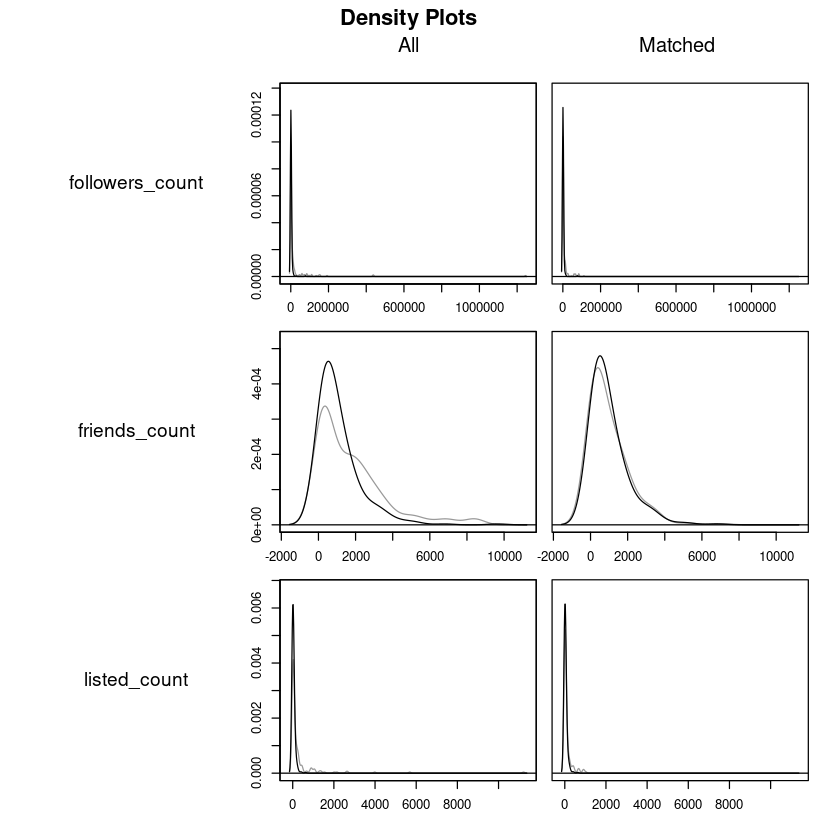

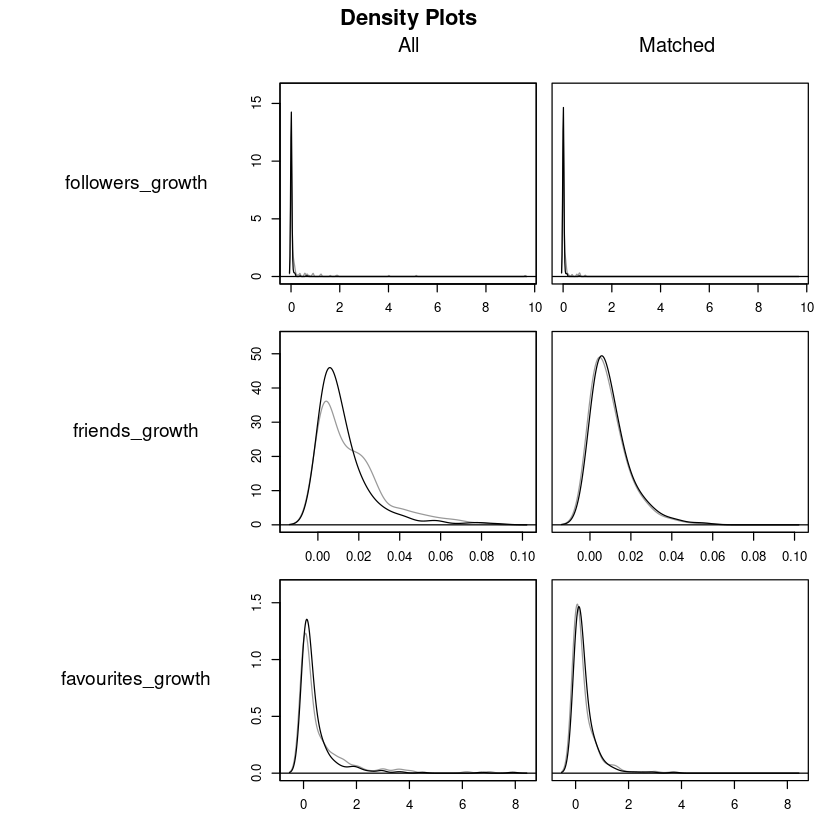

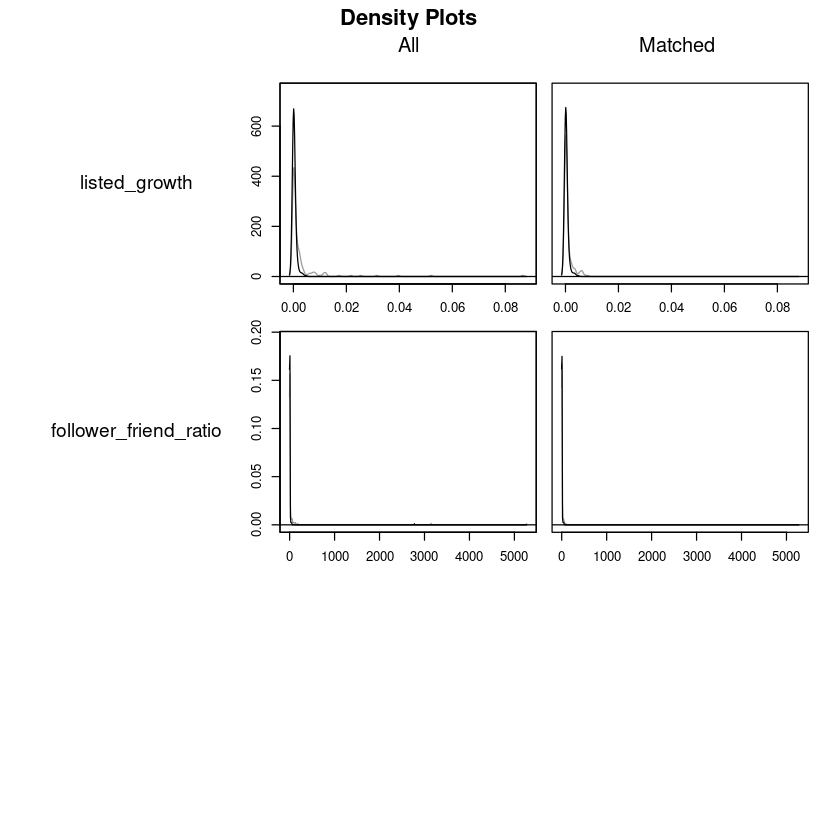

In [21]:
#plot(m.out, type = "jitter")
plot(m.out, type = "density")

In [207]:
matched_data <- match.data(m.out)

In [208]:
ps_matched <- matched_data %>% filter(bot_interaction==0) %>%
                               select(author_id_)

In [209]:
common_elements <- intersect(matched_data$author_id_, sample_and_matching[sample_and_matching$bot_interaction==0,]$author_id_)

In [210]:
matched_uid <- matched_data$author_id

In [211]:
#length(common_elements)

In [212]:
#filtered_sample_and_matching <- all_eculid_availables %>%
#  filter(matched_user %in% common_elements)

In [213]:
#nrow(filtered_sample_and_matching)

In [214]:
#ps_available = c(filtered_sample_and_matching$uid, filtered_sample_and_matching$matched_uid)

In [215]:
filtered_bot_days_data <- bot_days_data %>%
  filter(author_id_ %in% matched_uid)

In [216]:
filtered_bot_days_data_full_sample <- bot_days_data %>%
  filter(bot_interaction == 1 | (bot_interaction == 0 & author_id_ %in% common_elements))

In [217]:
filtered_bot_days_data_opinion <- bot_days_data_opinion %>%
  filter(author_id_ %in% matched_uid)

In [218]:
filtered_bot_days_data_opinion_full_sample <- bot_days_data_opinion %>%
  filter(bot_interaction == 1 | (bot_interaction == 0 & author_id_ %in% common_elements))

In [219]:
filtered_bot_days_data2 <- bot_days_data2 %>%
  filter(author_id_ %in% matched_uid)

filtered_bot_days_data2_full_sample <- bot_days_data2 %>%
  filter(bot_interaction == 1 | (bot_interaction == 0 & author_id_ %in% common_elements))

In [220]:
write.csv(filtered_bot_days_data, "./SR_REVISION/propensity_filtered_for_reg_BOTH_FILTERED.csv", row.names = FALSE)
write.csv(filtered_bot_days_data_full_sample,  "./SR_REVISION/propensity_filtered_for_reg_MATCHED_ONLY.csv", row.names = FALSE)

In [221]:
write.csv(filtered_bot_days_data_opinion, "./SR_REVISION/propensity_filtered_for_reg_opinion_BOTH_FILTERED.csv", row.names = FALSE)
write.csv(filtered_bot_days_data_opinion_full_sample,  "./SR_REVISION/propensity_filtered_for_reg_opinion_MATCHED_ONLY.csv", row.names = FALSE)

In [222]:
write.csv(filtered_bot_days_data_opinion, "./SR_REVISION/propensity_filtered_for_reg2_BOTH_FILTERED.csv", row.names = FALSE)
write.csv(filtered_bot_days_data_opinion_full_sample,  "./SR_REVISION/propensity_filtered_for_reg2_MATCHED_ONLY.csv", row.names = FALSE)

## CEM

In [ ]:
install.packages("Matching")


In [111]:
library(Matching)

In [15]:
covariates <- sample_and_matching %>% select('statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'followers_growth', 'friends_growth', 'favourites_growth',
       'listed_growth', 'follower_friend_ratio')

In [18]:
covariates <- c('statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'followers_growth', 'friends_growth', 'favourites_growth',
       'listed_growth', 'follower_friend_ratio')

# Perform Coarsened Exact Matching
cem_match <- cem(treatment = "bot_interaction", data = df, keep.all=TRUE)

# Summary of the matching
summary()


Using 'bot_interaction'='1' as baseline group


ERROR: Error in is.factor(object): argument "object" is missing, with no default


Executing 57 different relaxations
  |                                                                      |   0%
matching on variables:author_id_ statuses_count followers_count friends_count favourites_count listed_count followers_growth friends_growth favourites_growth listed_growth follower_friend_ratio

CEM Subclasses: 0

Sample sizes:
           G0  G1
All       179 303
Matched   130 258
Unmatched  49  45
author_id_(1)

matching on variables:author_id_ statuses_count followers_count friends_count favourites_count listed_count followers_growth friends_growth favourites_growth listed_growth follower_friend_ratio

CEM Subclasses: 0

Sample sizes:
           G0  G1
All       179 303
Matched   130 246
Unmatched  49  57
author_id_(2)

matching on variables:author_id_ statuses_count followers_count friends_count favourites_count listed_count followers_growth friends_growth favourites_growth listed_growth follower_friend_ratio

CEM Subclasses: 0

Sample sizes:
           G0  G1
All      

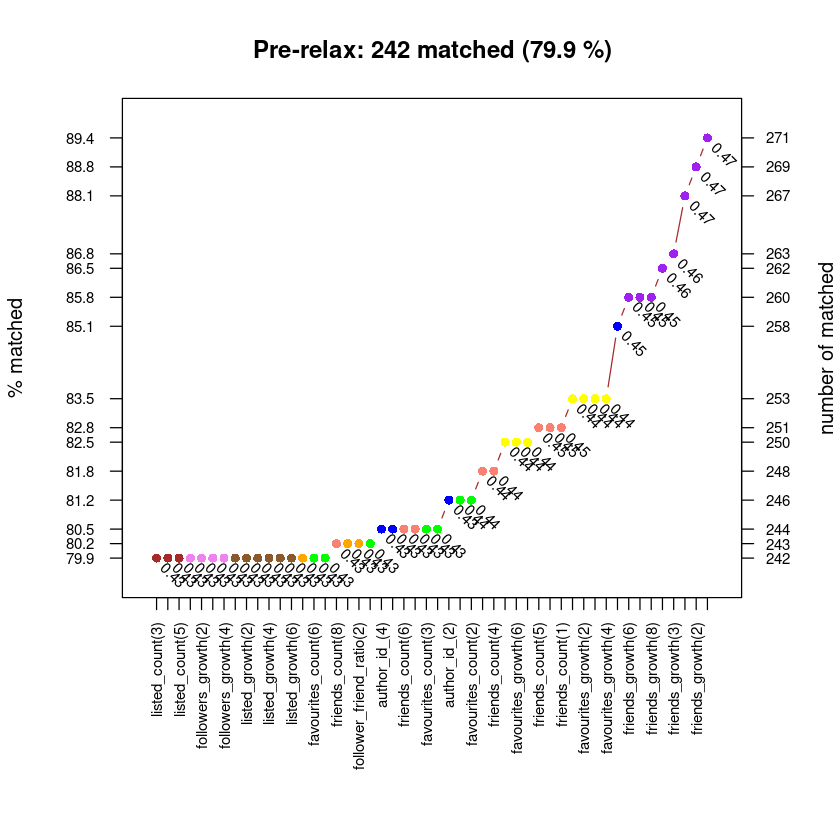

In [19]:
tab <- relax.cem(cem_match, df, depth=1, perc=0.3)